In [2]:
# Importamos las librerias necesarias para trabajar
from statsmodels.regression.linear_model import yule_walker
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from numpy.fft import fft, fftfreq, fftshift
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy import signal
from sqlalchemy import create_engine
from numpy.linalg import pinv
from matplotlib import cm
from datetime import time
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy as sp
import mysql.connector
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import copy
import sklearn

# Seteamos el estilo de los graficos
sns.set(style="whitegrid")

# Configuramos los graficos con latex
plt.rc('text', usetex=True)

# Funcion para la metrica de la trayectoria
def error_trayectoria(vector):
    '''
    Se calcula una norma de error como la diferencia entre la prediccion y la medicion
    real para un tiempo t. Se utilizara la norma euclidiana
    '''
    y_predict = vector['y+1':'y+6']
    y_real = vector['y']
    error = (y_predict - y_real) ** 2
    error = sum(error) / len(error)
    return np.sqrt(error)

def phi_X(R_X, gamma, Ts=5 * 60):
    arg_max = R_X.argmax()
    R_X_wind = R_X[arg_max - gamma: arg_max + gamma + 1]
    wind = np.hanning(len(R_X_wind))
    phi_X = fft(R_X_wind * wind)
    freq = fftfreq(len(phi_X), Ts)
    phi_X = pd.Series(phi_X, index=freq)
    phi_X = phi_X[freq > 0]
    return phi_X

def lowPassFilter(serie, window=5):
    serie_out = list()
    serie_out.append(serie[0])
    for i in range(1,len(serie)):
        values = serie[:i]
        value= values[-window:]
        serie_out.append(value.mean())
    return np.array(serie_out)

def periodograma(serie, Ts=5*60):
    N = len(serie)
    freq = fftfreq(N, Ts)
    S = fft(serie, norm='ortho')
    S_N = abs(S) ** 2
    S_N = pd.Series(S_N, index=freq)
    return S_N[freq > 0]

def arx(data, orders, Q=None):
    '''
    Modelo ARX para un sistema MISO
    '''
    # Creamos los parametros del modelo
    N = len(data)            # int:  Tamano total de los datos
    na = orders[0]           # int:  Orden de la regresion
    Nb = orders[1:]          # list: Ordenes de las entradas exogenas
    max_order = max(orders)  # int:  Orden maximo entre la regresion y las entradas exogenas
    d = sum(orders)          # int:  Tamano de los vectores de regresion
    
    # Separamos las series de tiempo en salida y entradas
    y = data.iloc[:,0].to_numpy()     # Salida:  tamano N x 1
    y = y.reshape(len(y), 1)
    U = data.iloc[:,1:].to_numpy()    # Entrada: tamano N x len(Nb)     
    
    # Verificamos que el tamano de los ordenes de las entradas tenga el mismo tamano de las series
    # de tiempo de las entradas
    if len(Nb) != U.shape[1]:
        print('Problemas de tamano: Tamano incorrecto entre Nb ({}) y series de entradas ({})'
              .format(len(Nb), U.shape[1]))
        return
    
    
    # Generamos el vector de salida de la prediccion
    Y_N = y[max_order:]    # Tamano: N - max_order x 1
    
    # Generamos la matriz de datos
    Phi_N = np.zeros([N-max_order, d])  # Tamano: N - max_order  x d 
    
    # Iteramos para llenar la matriz con la variable autoregresiva
    for i in range(na):
        Phi_N[:,i] = - y[max_order - i - 1:-i - 1].T
    
    # Iteramos para llenar la matriz con las variables de entradas
    
    col_count = na   # Contador para almacenar el indice de la columna donde guardar los datos en Phi_N
    for j in range(len(Nb)):    # Iteramos para cada serie de entrada
        nb = Nb[j]              # Orden de la serie utilizada
        u_actual = U[:,j]       # Extraemos la columna utilizada
        for i in range(nb):
            Phi_N[:, col_count] = u_actual[max_order - i - 1:-i - 1]
            col_count += 1

    # Si la matriz Q no esta especificada, calculamos el vector theta de parametros con la pseudo inversa
    if Q is None:
        theta_N = np.dot(np.linalg.pinv(Phi_N), Y_N)
        return theta_N
    # En caso contrario, se utiliza la formula que utiliza la inversa explicida y la matriz Q
    else:
        Q = Q[max_order:, max_order:]
        Phi_Q_Phi = np.dot(np.dot(Phi_N.T, Q), Phi_N)
        Phi_Q_Y = np.dot(np.dot(Phi_N.T, Q), Y_N)
        theta_N = np.dot(np.linalg.inv(Phi_Q_Phi), Phi_Q_Y)
        return theta_N
    
def k_step_predict(data, orders, theta, k=1):
    # Creamos los parametros del modelo
    N = len(data)            # int:  Tamano total de los datos
    na = orders[0]           # int:  Orden de la regresion
    Nb = orders[1:]          # list: Ordenes de las entradas exogenas
    max_order = max(orders)  # int:  Orden maximo entre la regresion y las entradas exogenas
    d = sum(orders)          # int:  Tamano de los vectores de regresion
    
    # Separamos las series de tiempo en salida y entradas
    y = data.iloc[:,0].to_numpy()     # Salida:  tamano N x 1
    y = y.reshape(len(y), 1)
    U = data.iloc[:,1:].to_numpy()    # Entrada: tamano N x len(Nb)
    
    # Verificamos que el tamano de los ordenes de las entradas tenga el mismo tamano de las series
    # de tiempo de las entradas
    if len(Nb) != U.shape[1]:
        print('Problemas de tamano: Tamano incorrecto entre Nb ({}) y series de entradas ({})'
              .format(len(Nb), U.shape[1]))
        return
    
    
    N_columns = N - max_order - k + 1    # Numero de columnas de salida. Desde n+k hasta N
    
    # Generamos las matrices de regresion para cada variable
    phi_y = np.zeros([na + k, N_columns]);
    
    # iteramos para llenar la matriz de y
    for i in range(na):
        phi_y[i + k,:] = -y[na-i-1:-i-k].T
    
    phi_u_matrix = list()
    
    count = 0
    for j in range(len(Nb)):
        nb = Nb[j]
        phi_u = np.zeros([nb + k, N_columns]);
        u = U[:,j]
        for i in range(nb + k):
            phi_u[i,:] = u[nb + k -i-1:N-i]
        phi_u_matrix.append(phi_u)
        
    for i in range(k):
        phi_u_matrix_buff = list()
        for phi_u in phi_u_matrix:
            phi_u_matrix_buff.append(phi_u[k - i:k + max_order - i, :])
        phi_u = np.concatenate(phi_u_matrix_buff)
        phi = np.concatenate([phi_y[k - i:k + max_order - i, :], phi_u])
        phi_y[k - i - 1, :] = - np.dot(theta.T, phi);
    
    columns_name = ['k+{}'.format(i) for i in range(1, k+1)]
    predict = pd.DataFrame(index=data.index, columns=columns_name)
    predict = predict.iloc[max_order:,:]
    predict.iloc[:-k+1,:] = np.flip(-phi_y[0:k,:].T, axis=1)
    
    for i in range(len(columns_name)):
        column = columns_name[i]
        predict[column] = predict[column].shift(i)
    
    return predict

In [3]:
# Extraemos la salida
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='output_y'
)

# Extraemos la informacion en un dataframe
y = pd.read_sql("SELECT datetime, y FROM y1", mydb)   # Cargamos todos los datos
y.set_index('datetime', inplace=True)                 # Definimos datetime como indice
y.sort_index(inplace=True)                            # Ordenamos en base a datetime

# Extraemos las entradas
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7461143',
    database='input_u'
)

# Extraemos la informacion de la entrada de los bolos
u_bolo = pd.read_sql("SELECT * FROM u_bolo", mydb)    # Cargamos todos los datos
u_bolo.set_index('datetime', inplace=True)            # Definimos el datetime como indice
u_bolo.sort_index(inplace=True)                       # Ordenamos los datos en base a datetime

# Extraemos la informacion de la entrada de los bolos
u_meal = pd.read_sql("SELECT * FROM u_meal", mydb)    # Cargamos todos los datos
u_meal.set_index('datetime', inplace=True)            # Definimos el datetime como indice
u_meal.sort_index(inplace=True)                       # Ordenamos los datos en base a datetime

# Extraemos la informacion de la entrada de los bolos
u_holter = pd.read_sql("SELECT * FROM u_holter", mydb)  # Cargamos todos los datos
u_holter.set_index('datetime', inplace=True)            # Definimos el datetime como indice
u_holter.sort_index(inplace=True)                       # Ordenamos los datos en base a datetime

# Extraemos la informacion de la entrada de los bolos
u_equivital = pd.read_sql("SELECT * FROM u_equivital", mydb)    # Cargamos todos los datos
u_equivital.set_index('datetime', inplace=True)                 # Definimos el datetime como indice
u_equivital.sort_index(inplace=True)                            # Ordenamos los datos en base a datetime

# Unimos los datos
data = y.join([u_bolo, u_meal, u_holter, u_equivital])

# Mostramos los resultados
data.index.freq = pd.infer_freq(data.index)

print('Tamano de la tabla: {} filas y {} columnas'.format(data.shape[0], data.shape[1]))
print('Tiempo del estudio:')
print(' - Inicio  : {}'.format(str(data.index[0])))
print(' - Final   : {}'.format(str(data.index[-1])))
print(' - Duración: {}'.format(str(data.index[-1] - data.index[0])))
data.head(3)

Tamano de la tabla: 1728 filas y 22 columnas
Tiempo del estudio:
 - Inicio  : 2020-01-24 17:00:00
 - Final   : 2020-01-30 16:55:00
 - Duración: 5 days 23:55:00


,y,u_bolo_delta,u_bolo_gauss,u_bolo_hov,u_bolo_biexp,u_bolo_rem,u_meal_delta,u_meal_gauss,u_meal_hov,u_meal_rem,...,u_holter_HR,u_holter_mean,u_equivital_HR,u_equivital_BR,u_equivital_temp,u_equivital_RR,u_equivital_BW,u_equivital_lat_acc,u_equivital_long_acc,u_equivital_ver_acc
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-24 17:00:00,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24 17:05:00,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24 17:10:00,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Extraemos los dataframes para entrenar

data_eq = copy.copy(data[['y',
                'u_bolo_hov', 
                'u_meal_hov', 
                'u_equivital_HR', 
                'u_equivital_BR', 
                'u_equivital_RR',
                'u_equivital_temp',
                'u_equivital_lat_acc',
                'u_equivital_long_acc',
                'u_equivital_ver_acc']
              ])
data_eq.dropna(inplace=True)

# Primer grupo
data_eq1 = data_eq['2020-01-24':'2020-01-25']
data_eq1 = data_eq1[:-2] # Ultimos dos valores no dan valores fiables

# Segundo grupo
data_eq2 = data_eq['2020-01-27':'2020-01-28']

# Tercer grupo
data_eq3 = data_eq['2020-01-29':'2020-01-30']
data_eq3 = data_eq3[:-1]

print('tamano set 1: {}'.format(len(data_eq1)))
print('tamano set 2: {}'.format(len(data_eq2)))
print('tamano set 3: {}'.format(len(data_eq3)))

data_eq1.head(3)

tamano set 1: 147
tamano set 2: 95
tamano set 3: 143


,y,u_bolo_hov,u_meal_hov,u_equivital_HR,u_equivital_BR,u_equivital_RR,u_equivital_temp,u_equivital_lat_acc,u_equivital_long_acc,u_equivital_ver_acc
datetime,,,,,,,,,,
2020-01-24 19:25:00,257.0,6.825734,24.360351,103.700000,4.000000,547.113636,30.86,-123.464496,-128.754076,-740.177395
2020-01-24 19:30:00,261.0,6.524769,22.393682,98.631250,17.541667,611.559184,32.40,-140.348711,59.057070,-924.960664
2020-01-24 19:35:00,258.0,6.224567,20.552849,97.778947,17.122222,614.940574,33.43,-123.702109,11.094688,-923.193984


## Primer grupo

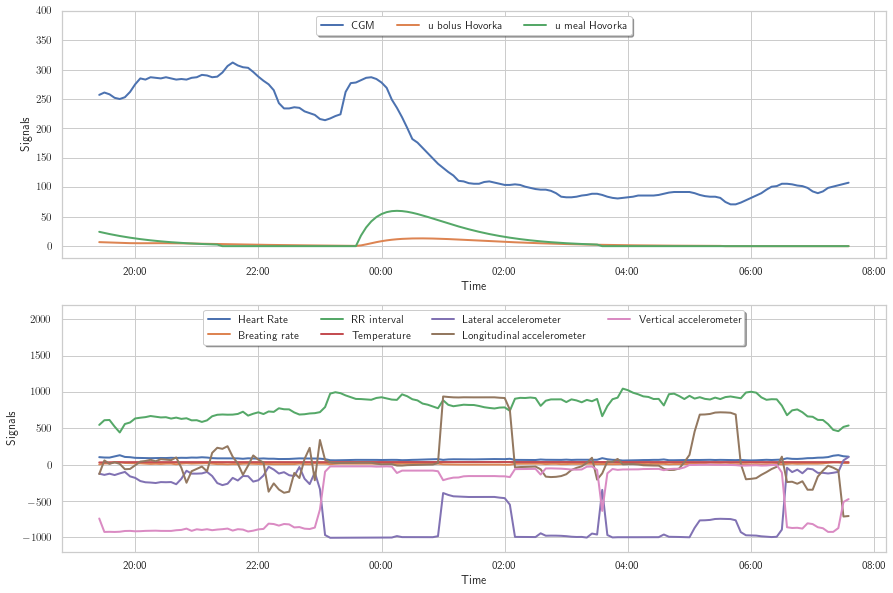

In [31]:
# Graficamos los datos
fig, (ax1, ax2) = plt.subplots(2, 1)

# Grafico superior
ax1.plot(data_eq1['y'],           color='C0', linewidth=2.0, linestyle='-', label='CGM')
ax1.plot(data_eq1['u_bolo_hov'],  color='C1', linewidth=2.0, linestyle='-', label='u bolus Hovorka')
ax1.plot(data_eq1['u_meal_hov'],  color='C2', linewidth=2.0, linestyle='-', label='u meal Hovorka')

# Grafico inferior
ax2.plot(data_eq1['u_equivital_HR'],       color='C0', linewidth=2.0, linestyle='-', label='Heart Rate')
ax2.plot(data_eq1['u_equivital_BR'],       color='C1', linewidth=2.0, linestyle='-', label='Breating rate')
ax2.plot(data_eq1['u_equivital_RR'],       color='C2', linewidth=2.0, linestyle='-', label='RR interval')
ax2.plot(data_eq1['u_equivital_temp'],     color='C3', linewidth=2.0, linestyle='-', label='Temperature')
ax2.plot(data_eq1['u_equivital_lat_acc'],  color='C4', linewidth=2.0, linestyle='-', label='Lateral accelerometer')
ax2.plot(data_eq1['u_equivital_long_acc'], color='C5', linewidth=2.0, linestyle='-', label='Longitudinal accelerometer')
ax2.plot(data_eq1['u_equivital_ver_acc'],  color='C6', linewidth=2.0, linestyle='-', label='Vertical accelerometer')


# Parametros
ax1.grid(True)
ax1.set_ylabel('Signals')
ax1.set_xlabel('Time')
ax1.set_ylim([-20, 400])
ax1.legend(loc='upper center', ncol=5, fancybox=True, shadow=True)

ax2.grid(True)
ax2.set_ylabel('Signals')
ax2.set_xlabel('Time')
ax2.set_ylim([-1200, 2200])
ax2.legend(loc='upper center', ncol=4, fancybox=True, shadow=True)


# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

y_size = 2 * 4.2
x_size = 3 / 2 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

## Segundo grupo

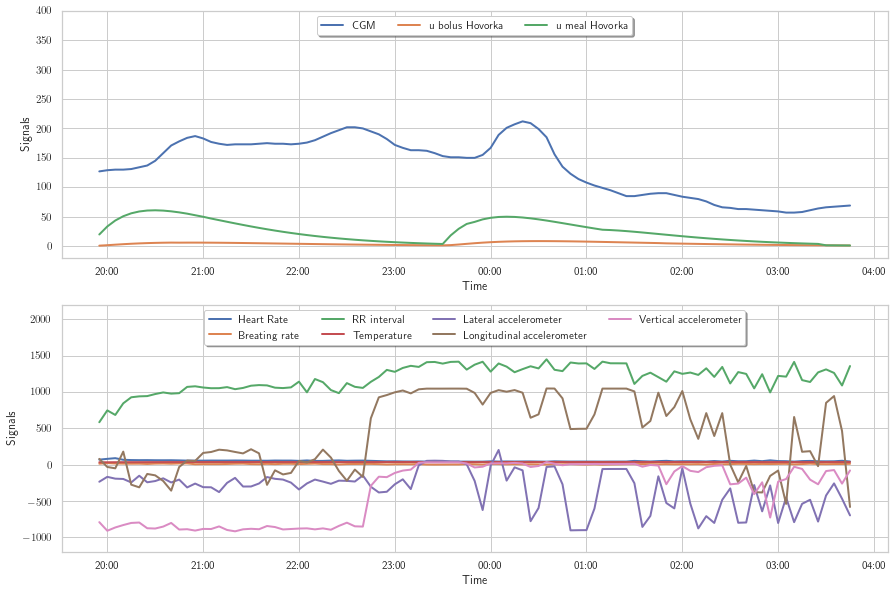

In [30]:
# Graficamos los datos
fig, (ax1, ax2) = plt.subplots(2, 1)

# Grafico superior
ax1.plot(data_eq2['y'],           color='C0', linewidth=2.0, linestyle='-', label='CGM')
ax1.plot(data_eq2['u_bolo_hov'],  color='C1', linewidth=2.0, linestyle='-', label='u bolus Hovorka')
ax1.plot(data_eq2['u_meal_hov'],  color='C2', linewidth=2.0, linestyle='-', label='u meal Hovorka')

# Grafico inferior
ax2.plot(data_eq2['u_equivital_HR'],       color='C0', linewidth=2.0, linestyle='-', label='Heart Rate')
ax2.plot(data_eq2['u_equivital_BR'],       color='C1', linewidth=2.0, linestyle='-', label='Breating rate')
ax2.plot(data_eq2['u_equivital_RR'],       color='C2', linewidth=2.0, linestyle='-', label='RR interval')
ax2.plot(data_eq2['u_equivital_temp'],     color='C3', linewidth=2.0, linestyle='-', label='Temperature')
ax2.plot(data_eq2['u_equivital_lat_acc'],  color='C4', linewidth=2.0, linestyle='-', label='Lateral accelerometer')
ax2.plot(data_eq2['u_equivital_long_acc'], color='C5', linewidth=2.0, linestyle='-', label='Longitudinal accelerometer')
ax2.plot(data_eq2['u_equivital_ver_acc'],  color='C6', linewidth=2.0, linestyle='-', label='Vertical accelerometer')


# Parametros
ax1.grid(True)
ax1.set_ylabel('Signals')
ax1.set_xlabel('Time')
ax1.set_ylim([-20, 400])
ax1.legend(loc='upper center', ncol=5, fancybox=True, shadow=True)

ax2.grid(True)
ax2.set_ylabel('Signals')
ax2.set_xlabel('Time')
ax2.set_ylim([-1200, 2200])
ax2.legend(loc='upper center', ncol=4, fancybox=True, shadow=True)


# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

y_size = 2 * 4.2
x_size = 3 / 2 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

## Tercer grupo

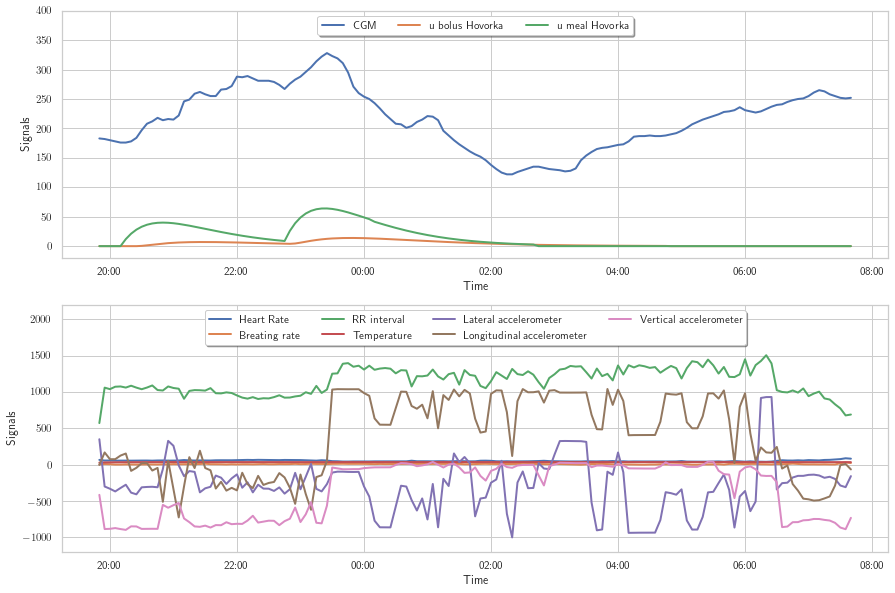

In [32]:
# Graficamos los datos
fig, (ax1, ax2) = plt.subplots(2, 1)

# Grafico superior
ax1.plot(data_eq3['y'],           color='C0', linewidth=2.0, linestyle='-', label='CGM')
ax1.plot(data_eq3['u_bolo_hov'],  color='C1', linewidth=2.0, linestyle='-', label='u bolus Hovorka')
ax1.plot(data_eq3['u_meal_hov'],  color='C2', linewidth=2.0, linestyle='-', label='u meal Hovorka')

# Grafico inferior
ax2.plot(data_eq3['u_equivital_HR'],       color='C0', linewidth=2.0, linestyle='-', label='Heart Rate')
ax2.plot(data_eq3['u_equivital_BR'],       color='C1', linewidth=2.0, linestyle='-', label='Breating rate')
ax2.plot(data_eq3['u_equivital_RR'],       color='C2', linewidth=2.0, linestyle='-', label='RR interval')
ax2.plot(data_eq3['u_equivital_temp'],     color='C3', linewidth=2.0, linestyle='-', label='Temperature')
ax2.plot(data_eq3['u_equivital_lat_acc'],  color='C4', linewidth=2.0, linestyle='-', label='Lateral accelerometer')
ax2.plot(data_eq3['u_equivital_long_acc'], color='C5', linewidth=2.0, linestyle='-', label='Longitudinal accelerometer')
ax2.plot(data_eq3['u_equivital_ver_acc'],  color='C6', linewidth=2.0, linestyle='-', label='Vertical accelerometer')


# Parametros
ax1.grid(True)
ax1.set_ylabel('Signals')
ax1.set_xlabel('Time')
ax1.set_ylim([-20, 400])
ax1.legend(loc='upper center', ncol=5, fancybox=True, shadow=True)

ax2.grid(True)
ax2.set_ylabel('Signals')
ax2.set_xlabel('Time')
ax2.set_ylim([-1200, 2200])
ax2.legend(loc='upper center', ncol=4, fancybox=True, shadow=True)


# Formato de las fechas
date_form = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

y_size = 2 * 4.2
x_size = 3 / 2 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

# Modelo ARX

## Entrenamiento con conjunto 1 y prueba con conjunto 2

procesando u_meal_hov
procesando u_equivital_HR
procesando u_equivital_BR
procesando u_equivital_RR
procesando u_equivital_temp
procesando u_equivital_lat_acc
procesando u_equivital_long_acc
procesando u_equivital_ver_acc


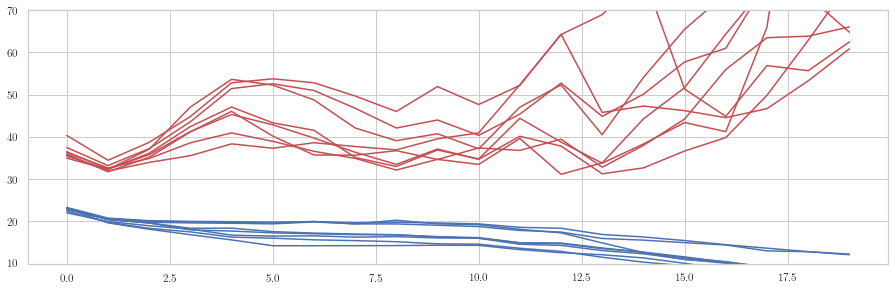

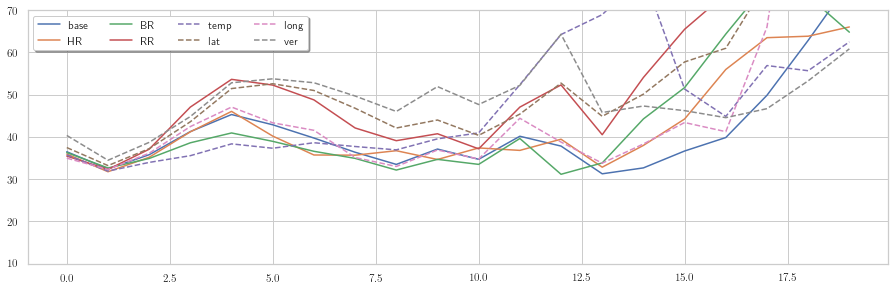

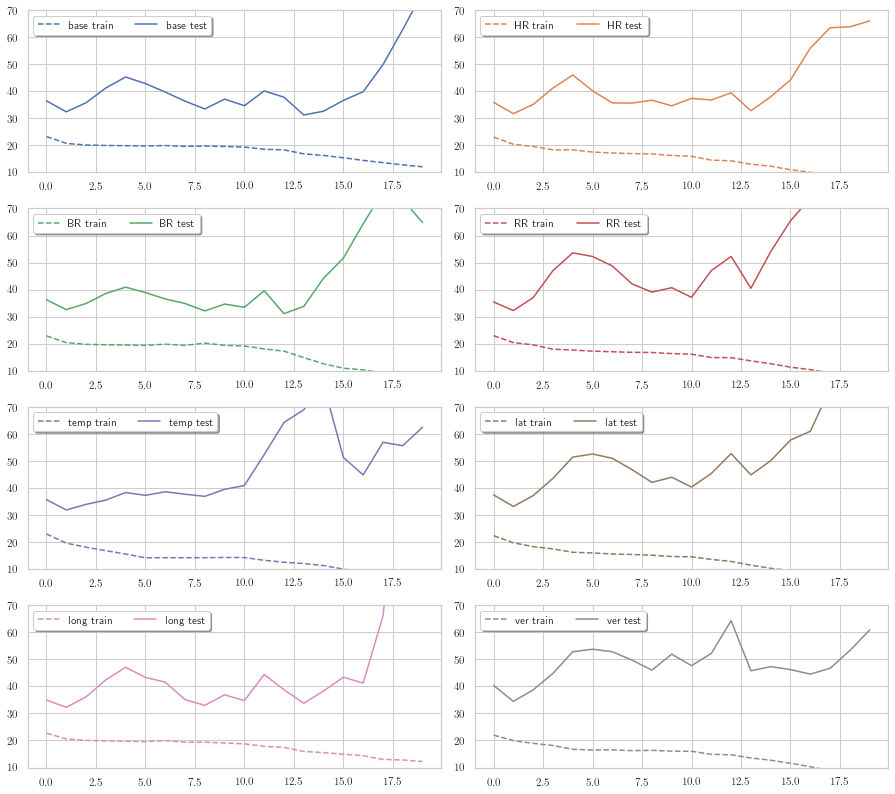

In [68]:
n_max = 20   # Orden maximo de regresion
k = 6        # Pasos de prediccion a futuro

conjuntos_datos = [['y','u_bolo_hov', 'u_meal_hov'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_HR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_BR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_RR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_temp'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_lat_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_long_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_ver_acc']]

nombre_conjuntos = [['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']]

RMSE_train_list = list()
RMSE_test_list = list()

for conjunto_datos in conjuntos_datos:
    print('procesando {}'.format(conjunto_datos[-1]))
    
    data_train = data_eq1[conjunto_datos]
    data_test  = data_eq2[conjunto_datos]
    
    RMSE_train = list()
    RMSE_test = list()
    
    for n in range(1, n_max + 1):
        
        theta = arx(data_train, len(conjunto_datos) * [n])

        Y_hat_train = k_step_predict(data_train, len(conjunto_datos) * [n], theta, k=k)
        Y_hat_test  = k_step_predict(data_test,  len(conjunto_datos) * [n], theta, k=k)

        y_hat_train = Y_hat_train.iloc[:,-1]
        y_hat_test  = Y_hat_test.iloc[ :,-1]


        error_train = y_hat_train - data_train['y']
        error_train = error_train[n_max + k - 1:]
        error_train.dropna()

        error_test = y_hat_test  - data_test[ 'y']
        error_test = error_test[n_max + k - 1:]
        error_test.dropna()



        rmse_train = np.sqrt(np.mean(error_train ** 2))
        rmse_test = np.sqrt(np.mean(error_test ** 2))

        RMSE_train.append(rmse_train)
        RMSE_test.append(rmse_test)
    RMSE_train_list.append(RMSE_train)
    RMSE_test_list.append(RMSE_test)
    
    
# Grafico 1

fig, ax = plt.subplots()
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_train_list[i], 'b', label='RMSE train')
    ax.plot(RMSE_test_list[i], 'r', label='RMSE test')
    
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 2

fig, ax = plt.subplots()
nombre_conjuntos = ['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']
estilos = ['-', '-', '-', '-', '--', '--', '--', '--']
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_test_list[i], label=nombre_conjuntos[i], linestyle=estilos[i])
    
ax.legend(fancybox='True', shadow='True', ncol=4)
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 3
colores = ['C0','C1','C2','C3','C4','C5','C6','C7']
fig, axs = plt.subplots(4, 2)
for i in range(len(axs)):
    (ax1, ax2) = axs[i]
    ax1.plot(RMSE_train_list[2*i], label=nombre_conjuntos[2*i] + ' train', linestyle='--', color=colores[2*i])
    ax1.plot(RMSE_test_list[2*i], label=nombre_conjuntos[2*i] + ' test', linestyle='-', color=colores[2*i])
    ax1.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax1.set_ylim([10, 70])
    
    ax2.plot(RMSE_train_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' train', linestyle='--', color=colores[2*i+1])
    ax2.plot(RMSE_test_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' test', linestyle='-', color=colores[2*i+1])
    ax2.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax2.set_ylim([10, 70])
    
y_size = 8 / 3 * 4.2
x_size = 3 * 4.2
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

## Entrenamiento con conjunto 1 y prueba con conjunto 3

procesando u_meal_hov
procesando u_equivital_HR
procesando u_equivital_BR
procesando u_equivital_RR
procesando u_equivital_temp
procesando u_equivital_lat_acc
procesando u_equivital_long_acc
procesando u_equivital_ver_acc


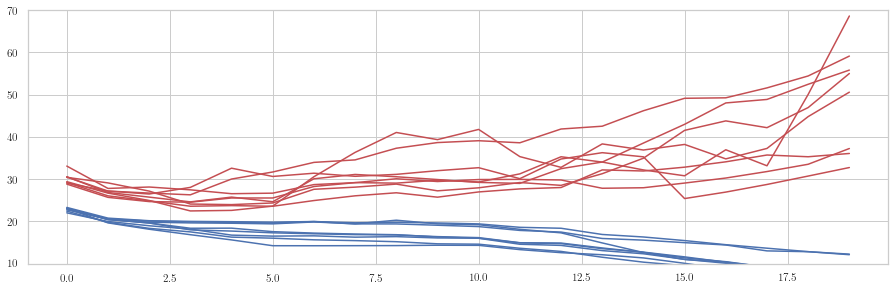

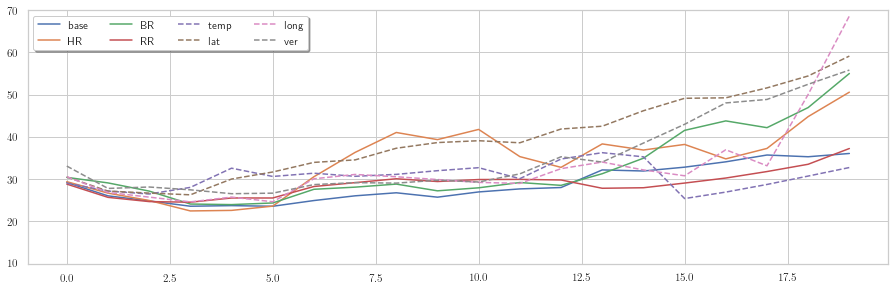

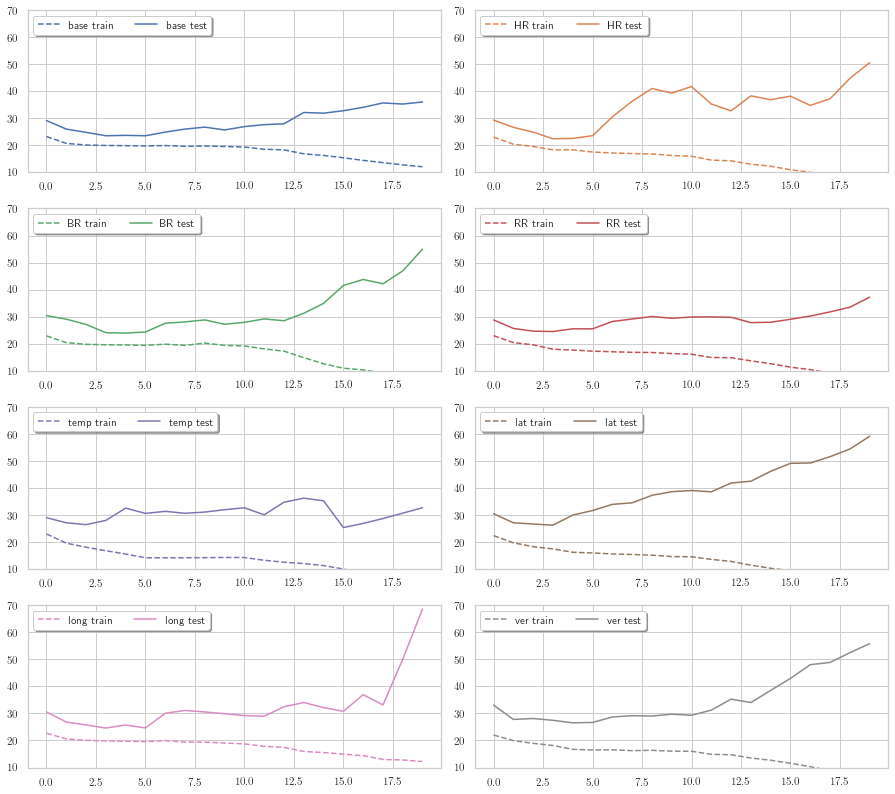

In [69]:
n_max = 20   # Orden maximo de regresion
k = 6        # Pasos de prediccion a futuro

conjuntos_datos = [['y','u_bolo_hov', 'u_meal_hov'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_HR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_BR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_RR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_temp'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_lat_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_long_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_ver_acc']]

nombre_conjuntos = [['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']]

RMSE_train_list = list()
RMSE_test_list = list()

for conjunto_datos in conjuntos_datos:
    print('procesando {}'.format(conjunto_datos[-1]))
    
    data_train = data_eq1[conjunto_datos]
    data_test  = data_eq3[conjunto_datos]
    
    RMSE_train = list()
    RMSE_test = list()
    
    for n in range(1, n_max + 1):
        
        theta = arx(data_train, len(conjunto_datos) * [n])

        Y_hat_train = k_step_predict(data_train, len(conjunto_datos) * [n], theta, k=k)
        Y_hat_test  = k_step_predict(data_test,  len(conjunto_datos) * [n], theta, k=k)

        y_hat_train = Y_hat_train.iloc[:,-1]
        y_hat_test  = Y_hat_test.iloc[ :,-1]


        error_train = y_hat_train - data_train['y']
        error_train = error_train[n_max + k - 1:]
        error_train.dropna()

        error_test = y_hat_test  - data_test[ 'y']
        error_test = error_test[n_max + k - 1:]
        error_test.dropna()



        rmse_train = np.sqrt(np.mean(error_train ** 2))
        rmse_test = np.sqrt(np.mean(error_test ** 2))

        RMSE_train.append(rmse_train)
        RMSE_test.append(rmse_test)
    RMSE_train_list.append(RMSE_train)
    RMSE_test_list.append(RMSE_test)
    
    
# Grafico 1

fig, ax = plt.subplots()
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_train_list[i], 'b', label='RMSE train')
    ax.plot(RMSE_test_list[i], 'r', label='RMSE test')
    
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 2

fig, ax = plt.subplots()
nombre_conjuntos = ['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']
estilos = ['-', '-', '-', '-', '--', '--', '--', '--']
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_test_list[i], label=nombre_conjuntos[i], linestyle=estilos[i])
    
ax.legend(fancybox='True', shadow='True', ncol=4)
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 3
colores = ['C0','C1','C2','C3','C4','C5','C6','C7']
fig, axs = plt.subplots(4, 2)
for i in range(len(axs)):
    (ax1, ax2) = axs[i]
    ax1.plot(RMSE_train_list[2*i], label=nombre_conjuntos[2*i] + ' train', linestyle='--', color=colores[2*i])
    ax1.plot(RMSE_test_list[2*i], label=nombre_conjuntos[2*i] + ' test', linestyle='-', color=colores[2*i])
    ax1.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax1.set_ylim([10, 70])
    
    ax2.plot(RMSE_train_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' train', linestyle='--', color=colores[2*i+1])
    ax2.plot(RMSE_test_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' test', linestyle='-', color=colores[2*i+1])
    ax2.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax2.set_ylim([10, 70])
    
y_size = 8 / 3 * 4.2
x_size = 3 * 4.2
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

## Entrenamiento con conjunto 2 y prueba con conjunto 3

procesando u_meal_hov
procesando u_equivital_HR
procesando u_equivital_BR
procesando u_equivital_RR
procesando u_equivital_temp
procesando u_equivital_lat_acc
procesando u_equivital_long_acc
procesando u_equivital_ver_acc


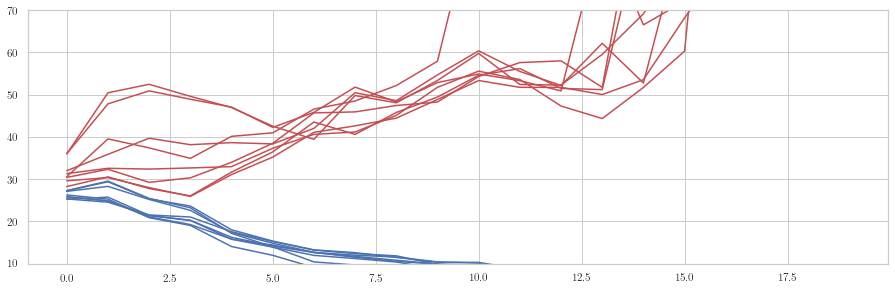

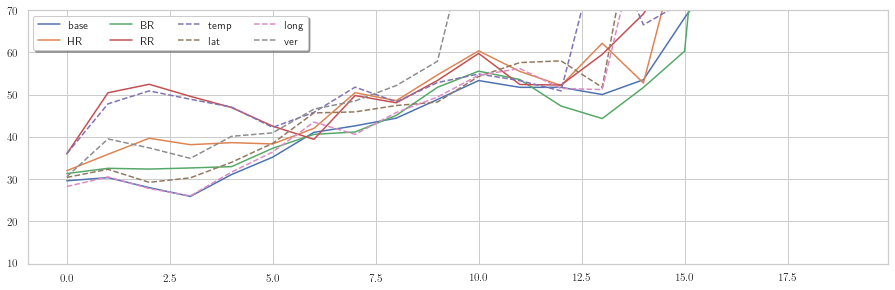

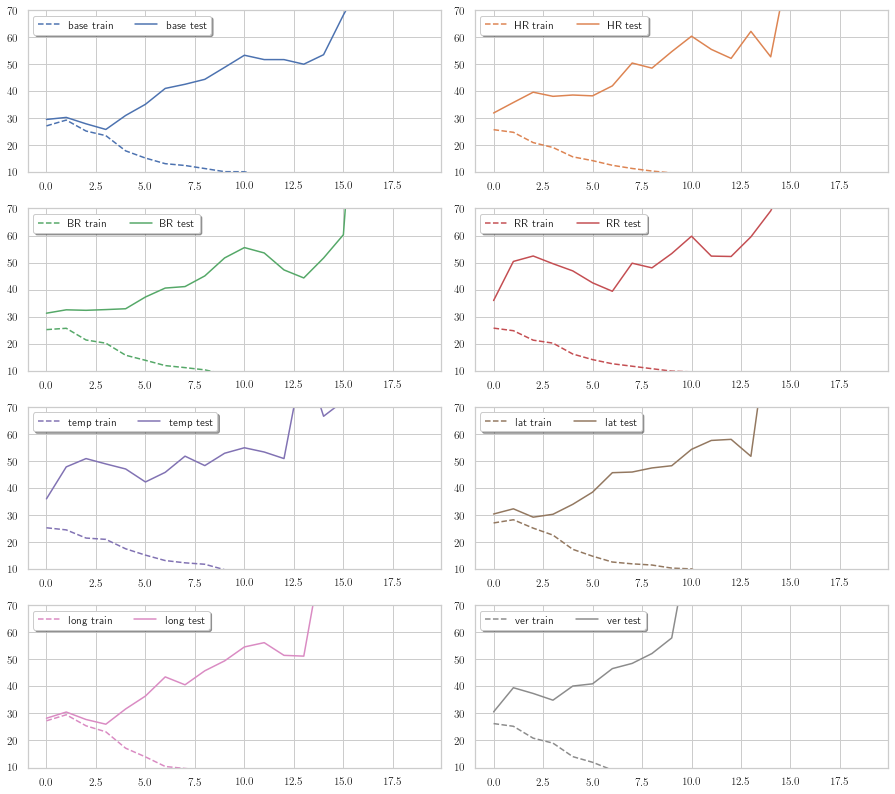

In [70]:
n_max = 20   # Orden maximo de regresion
k = 6        # Pasos de prediccion a futuro

conjuntos_datos = [['y','u_bolo_hov', 'u_meal_hov'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_HR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_BR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_RR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_temp'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_lat_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_long_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_ver_acc']]

nombre_conjuntos = [['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']]

RMSE_train_list = list()
RMSE_test_list = list()

for conjunto_datos in conjuntos_datos:
    print('procesando {}'.format(conjunto_datos[-1]))
    
    data_train = data_eq2[conjunto_datos]
    data_test  = data_eq3[conjunto_datos]
    
    RMSE_train = list()
    RMSE_test = list()
    
    for n in range(1, n_max + 1):
        
        theta = arx(data_train, len(conjunto_datos) * [n])

        Y_hat_train = k_step_predict(data_train, len(conjunto_datos) * [n], theta, k=k)
        Y_hat_test  = k_step_predict(data_test,  len(conjunto_datos) * [n], theta, k=k)

        y_hat_train = Y_hat_train.iloc[:,-1]
        y_hat_test  = Y_hat_test.iloc[ :,-1]


        error_train = y_hat_train - data_train['y']
        error_train = error_train[n_max + k - 1:]
        error_train.dropna()

        error_test = y_hat_test  - data_test[ 'y']
        error_test = error_test[n_max + k - 1:]
        error_test.dropna()



        rmse_train = np.sqrt(np.mean(error_train ** 2))
        rmse_test = np.sqrt(np.mean(error_test ** 2))

        RMSE_train.append(rmse_train)
        RMSE_test.append(rmse_test)
    RMSE_train_list.append(RMSE_train)
    RMSE_test_list.append(RMSE_test)
    
    
# Grafico 1

fig, ax = plt.subplots()
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_train_list[i], 'b', label='RMSE train')
    ax.plot(RMSE_test_list[i], 'r', label='RMSE test')
    
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 2

fig, ax = plt.subplots()
nombre_conjuntos = ['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']
estilos = ['-', '-', '-', '-', '--', '--', '--', '--']
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_test_list[i], label=nombre_conjuntos[i], linestyle=estilos[i])
    
ax.legend(fancybox='True', shadow='True', ncol=4)
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 3
colores = ['C0','C1','C2','C3','C4','C5','C6','C7']
fig, axs = plt.subplots(4, 2)
for i in range(len(axs)):
    (ax1, ax2) = axs[i]
    ax1.plot(RMSE_train_list[2*i], label=nombre_conjuntos[2*i] + ' train', linestyle='--', color=colores[2*i])
    ax1.plot(RMSE_test_list[2*i], label=nombre_conjuntos[2*i] + ' test', linestyle='-', color=colores[2*i])
    ax1.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax1.set_ylim([10, 70])
    
    ax2.plot(RMSE_train_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' train', linestyle='--', color=colores[2*i+1])
    ax2.plot(RMSE_test_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' test', linestyle='-', color=colores[2*i+1])
    ax2.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax2.set_ylim([10, 70])
    
y_size = 8 / 3 * 4.2
x_size = 3 * 4.2
fig.set_size_inches(x_size, y_size)
plt.tight_layout()

## Entrenamiento con conjunto 3 y prueba con conjunto 2

procesando u_meal_hov
procesando u_equivital_HR
procesando u_equivital_BR
procesando u_equivital_RR
procesando u_equivital_temp
procesando u_equivital_lat_acc
procesando u_equivital_long_acc
procesando u_equivital_ver_acc


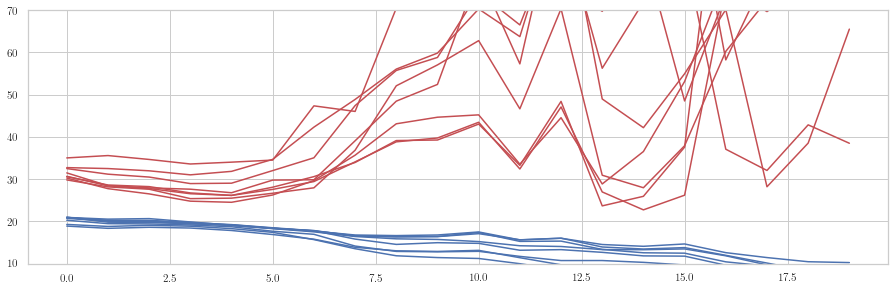

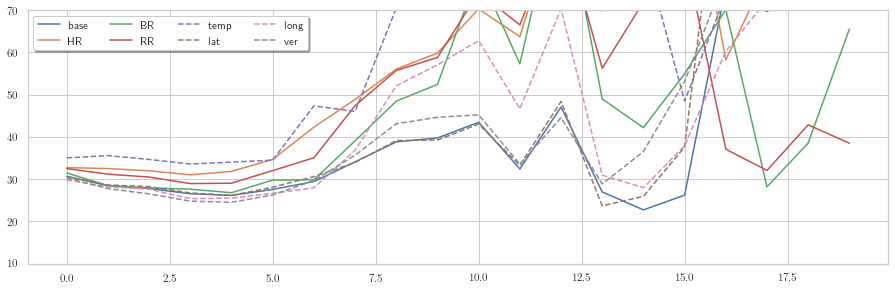

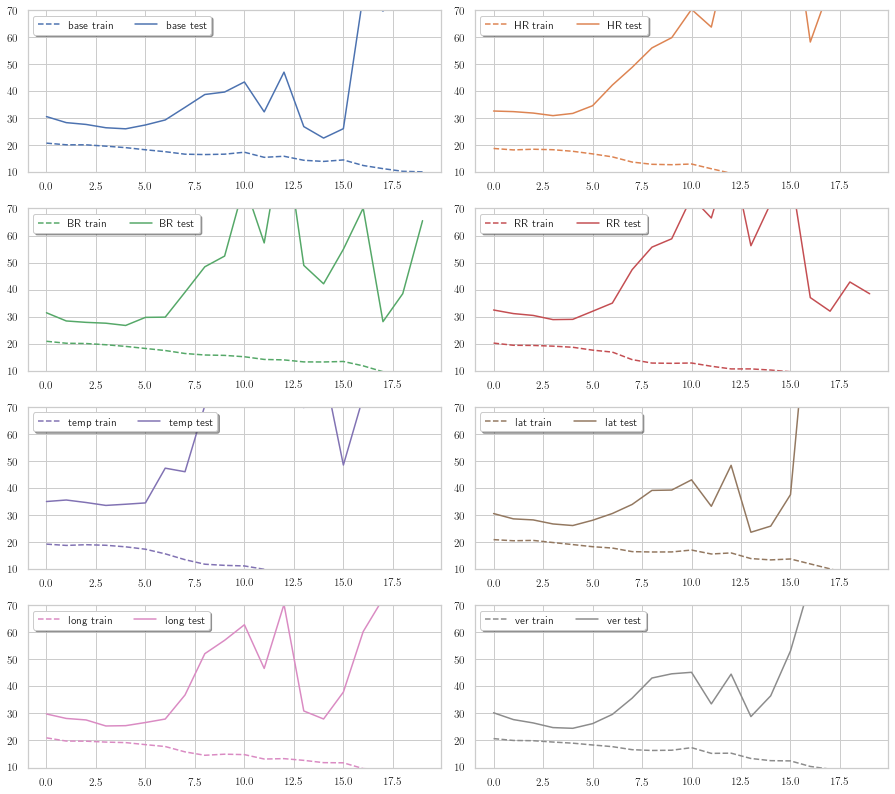

In [71]:
n_max = 20   # Orden maximo de regresion
k = 6        # Pasos de prediccion a futuro

conjuntos_datos = [['y','u_bolo_hov', 'u_meal_hov'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_HR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_BR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_RR'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_temp'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_lat_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_long_acc'],
    ['y','u_bolo_hov', 'u_meal_hov', 'u_equivital_ver_acc']]

nombre_conjuntos = [['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']]

RMSE_train_list = list()
RMSE_test_list = list()

for conjunto_datos in conjuntos_datos:
    print('procesando {}'.format(conjunto_datos[-1]))
    
    data_train = data_eq3[conjunto_datos]
    data_test  = data_eq2[conjunto_datos]
    
    RMSE_train = list()
    RMSE_test = list()
    
    for n in range(1, n_max + 1):
        
        theta = arx(data_train, len(conjunto_datos) * [n])

        Y_hat_train = k_step_predict(data_train, len(conjunto_datos) * [n], theta, k=k)
        Y_hat_test  = k_step_predict(data_test,  len(conjunto_datos) * [n], theta, k=k)

        y_hat_train = Y_hat_train.iloc[:,-1]
        y_hat_test  = Y_hat_test.iloc[ :,-1]


        error_train = y_hat_train - data_train['y']
        error_train = error_train[n_max + k - 1:]
        error_train.dropna()

        error_test = y_hat_test  - data_test[ 'y']
        error_test = error_test[n_max + k - 1:]
        error_test.dropna()



        rmse_train = np.sqrt(np.mean(error_train ** 2))
        rmse_test = np.sqrt(np.mean(error_test ** 2))

        RMSE_train.append(rmse_train)
        RMSE_test.append(rmse_test)
    RMSE_train_list.append(RMSE_train)
    RMSE_test_list.append(RMSE_test)
    
    
# Grafico 1

fig, ax = plt.subplots()
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_train_list[i], 'b', label='RMSE train')
    ax.plot(RMSE_test_list[i], 'r', label='RMSE test')
    
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 2

fig, ax = plt.subplots()
nombre_conjuntos = ['base', 'HR', 'BR', 'RR', 'temp', 'lat', 'long', 'ver']
estilos = ['-', '-', '-', '-', '--', '--', '--', '--']
for i in range(len(RMSE_train_list)):
    ax.plot(RMSE_test_list[i], label=nombre_conjuntos[i], linestyle=estilos[i])
    
ax.legend(fancybox='True', shadow='True', ncol=4)
ax.set_ylim([10, 70])
y_size = 4.2
x_size = 3 * y_size
fig.set_size_inches(x_size, y_size)
plt.tight_layout()


# Grafico 3
colores = ['C0','C1','C2','C3','C4','C5','C6','C7']
fig, axs = plt.subplots(4, 2)
for i in range(len(axs)):
    (ax1, ax2) = axs[i]
    ax1.plot(RMSE_train_list[2*i], label=nombre_conjuntos[2*i] + ' train', linestyle='--', color=colores[2*i])
    ax1.plot(RMSE_test_list[2*i], label=nombre_conjuntos[2*i] + ' test', linestyle='-', color=colores[2*i])
    ax1.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax1.set_ylim([10, 70])
    
    ax2.plot(RMSE_train_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' train', linestyle='--', color=colores[2*i+1])
    ax2.plot(RMSE_test_list[2*i+1], label=nombre_conjuntos[2*i+1] + ' test', linestyle='-', color=colores[2*i+1])
    ax2.legend(fancybox='True', shadow='True', loc='upper left', ncol=2)
    ax2.set_ylim([10, 70])
    
y_size = 8 / 3 * 4.2
x_size = 3 * 4.2
fig.set_size_inches(x_size, y_size)
plt.tight_layout()